## Driver code for training models to learn pipeline 1 x pipeline 2 transform maps
- Note: currently using output after atlas-based grouping
- Atlas used: aparc (Freesurfer) DKT-31 Mindboggle (ANTs: https://mindboggle.readthedocs.io/en/latest/labels.html) 

In [2]:
import sys
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

sys.path.append('../lib')
from data_handling import *
from data_stats import *

### Data paths

In [3]:
proj_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/'
#proj_dir = '/Users/nikhil/projects/compare-surf-tools/'
data_dir = proj_dir + 'data/'
fs60_dir = data_dir + 'fs60_group_stats/'
qc_dir =  '/home/nikhil/projects/CT_reproduce/data/QC/'
results_dir = data_dir + 'results/'

demograph_file = 'ABIDE_Phenotype.csv'
dkt_roi_names = 'DKT_parcel_map_FS_CIVET.csv'

ants_file = 'ABIDE_ants_thickness_data.csv' #uses modified (mindboggle) dkt atlas with 31 ROIs
civet_file = 'ABIDE_civet2.1_thickness_test1.csv'

fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv' 
fs60_lh_file = 'lh.aparc.thickness.table.test1' #'aparc_lh_thickness_table.txt' #'lh.aparc.thickness.table.test1'
fs60_rh_file = 'rh.aparc.thickness.table.test1' #'aparc_rh_thickness_table.txt' #'rh.aparc.thickness.table.test1'


### Global Vars

In [4]:
subject_ID_col = 'SubjID'

### Load data

In [5]:
# Demographics and Dx
demograph = pd.read_csv(data_dir + demograph_file)
demograph = demograph.rename(columns={'Subject_ID':subject_ID_col})

# ROI names
dkt_roi_map = pd.read_csv(data_dir + dkt_roi_names)

# CIVET 2.1
civet_data = pd.read_csv(data_dir + civet_file, dtype={subject_ID_col: str})
print('shape of civet data {}'.format(civet_data.shape))
civet_data_std = standardize_civet_data(civet_data, subject_ID_col, dkt_roi_map)
print('shape of stdized civet data {}'.format(civet_data_std.shape))
print('')

# ANTs
ants_data = pd.read_csv(data_dir + ants_file, header=2)
print('shape of ants data {}'.format(ants_data.shape))
ants_data_std = standardize_ants_data(ants_data, subject_ID_col)
print('shape of stdized ants data {}'.format(ants_data_std.shape))
print('')

# FS
fs53_data = pd.read_csv(data_dir + fs53_file)
print('shape of fs53 data {}'.format(fs53_data.shape))
fs53_data_std = standardize_fs_data(fs53_data, subject_ID_col)
print('shape of stdized fs53 data {}'.format(fs53_data_std.shape))
print('')

fs51_data = pd.read_csv(data_dir + fs51_file)
print('shape of fs51 data {}'.format(fs51_data.shape))
fs51_data_std = standardize_fs_data(fs51_data, subject_ID_col)
print('shape of stdized fs51 data {}'.format(fs51_data_std.shape))
print('')

fs60_lh_data = pd.read_csv(fs60_dir + fs60_lh_file, delim_whitespace=True)
fs60_rh_data = pd.read_csv(fs60_dir + fs60_rh_file, delim_whitespace=True)
print('shape of fs60 data l: {}, r: {}'.format(fs60_lh_data.shape,fs60_rh_data.shape))

fs60_data_std = standardize_fs60_data(fs60_lh_data, fs60_rh_data, subject_ID_col)
print('shape of stdized fs60 data {}'.format(fs60_data_std.shape))

shape of civet data (899, 65)
shape of stdized civet data (899, 65)

shape of ants data (1101, 99)
shape of stdized ants data (1101, 90)

shape of fs53 data (976, 74)
shape of stdized fs53 data (976, 74)

shape of fs51 data (1112, 74)
shape of stdized fs51 data (1112, 74)

shape of fs60 data l: (1047, 36), r: (1047, 36)
shape of left and right merge fs6.0 df (1047, 71)
shape of stdized fs60 data (1047, 71)


### Create master dataframe

In [6]:
data_dict = {'civet': civet_data_std,
            'fs60' : fs51_data_std}

na_action = 'drop' # options: ignore, drop; anything else will not use the dataframe for analysis. 
master_df_raw, common_subs, common_roi_cols = combine_processed_data(data_dict, subject_ID_col, na_action)

# Add demographic columns to the master_df_raw
useful_demograph = demograph[[subject_ID_col,'SEX','AGE_AT_SCAN','DX_GROUP','SITE_ID']].copy()

# DX_GROUP: (orginal: 1:ASD, 2:Controls, after shift 0:ASD, 1:Controls)
# Shift to (0 and 1 instead of 1 and 2 for statsmodels)
useful_demograph['DX_GROUP'] = useful_demograph['DX_GROUP']-1
useful_demograph['SEX'] = useful_demograph['SEX']-1
_,useful_demograph[subject_ID_col] = useful_demograph[subject_ID_col].str.rsplit('_', 1).str

master_df_raw = pd.merge(master_df_raw, useful_demograph, how='left', on=subject_ID_col)

print('\nmaster df shape after adding demographic info {}'.format(master_df_raw.shape))
print('\nNumber of common subjects {}({}), ROIs {}'.format(len(common_subs), master_df_raw[master_df_raw['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_roi_cols)))


Number of datasets: 2
Finding common subject and columns
dataset : fs60
common subs: 1112
dataset : civet
common subs: 899
Number of common subjects and columns: 899, 63

checking fs60 dataframe
Shape of the dataframe based on common cols and subs (899, 63)
Basic data check passed
Shape of the concat dataframe (899, 64)

checking civet dataframe
Shape of the dataframe based on common cols and subs (899, 63)
Basic data check passed
Shape of the concat dataframe (1798, 64)

master df shape after adding demographic info (1798, 68)

Number of common subjects 899({0: 432, 1: 467}), ROIs 62


### QC filters
- Manual (Gleb or Maarten)
- Automatic (Amadou) 

In [7]:
qc_type = 'None' #condition: master_df['QC_maarten']==0, master_df['QC_gleb'].isin['1','-+1']

if qc_type in ['maarten','gleb']:
    qc_df = pd.read_csv(qc_dir + 'master_QC_table.csv',dtype={'SubjID': str})
    master_df = pd.merge(master_df_raw, qc_df, how='left', on=subject_ID_col)
    master_df = master_df[master_df['QC_maarten']==0]
    print('Filtering based on {} QC. Resultant number of subjects {} ({}) (out of {})'.format(qc_type,len(master_df[subject_ID_col].unique()),master_df[master_df['pipeline']=='fs60']['DX_GROUP'].value_counts().to_dict(),len(common_subs)))
    common_subs = master_df[subject_ID_col].unique()
else:
    master_df = master_df_raw
    print('No QC performed. master_df shape {}'.format(len(master_df[subject_ID_col].unique())))
    


No QC performed. master_df shape 899


### Correlation between pipelines

In [8]:
possible_pairs = list(itertools.combinations(data_dict.keys(), 2))
xcorr_pairs_df = pd.DataFrame()
for pair in possible_pairs:
    pipe1 = pair[0]
    pipe2 = pair[1]
    df1 = master_df[master_df['pipeline']==pipe1][[subject_ID_col]+common_roi_cols]
    df2 = master_df[master_df['pipeline']==pipe2][[subject_ID_col]+common_roi_cols]
    xcorr_df = cross_correlations(df1,df2,subject_ID_col)
    xcorr_df['pipeline_pair'] = np.tile(str('{}-{}'.format(pair[0],pair[1])),len(xcorr_df))
    xcorr_pairs_df = xcorr_pairs_df.append(xcorr_df)
    print('Avg cross correlation between {} & {} = {:4.2f}\n'.format(pipe1,pipe2,np.mean(xcorr_df['correlation'].values)))
    

Avg cross correlation between fs60 & civet = 0.49



Shape of cross-corr df (62, 3), number of pairs 1


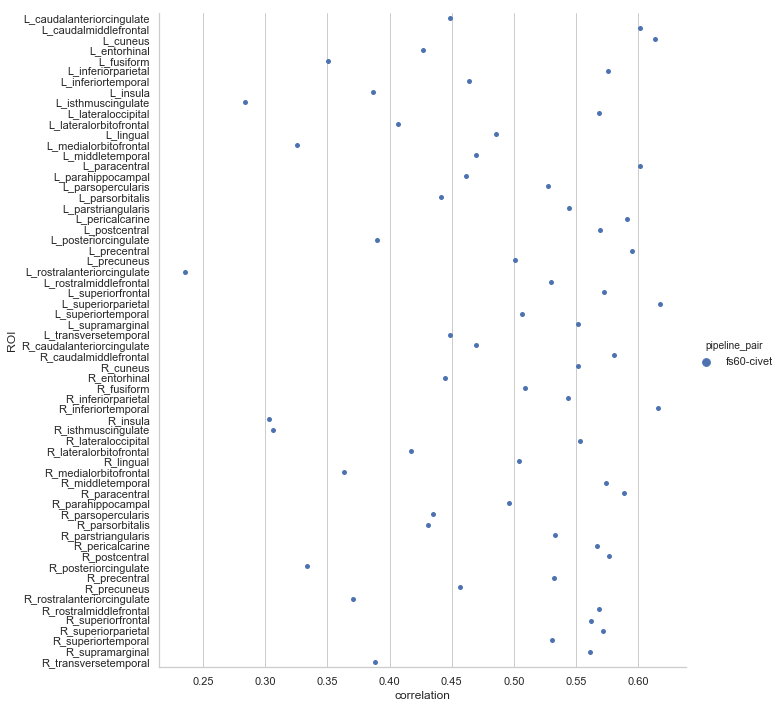

In [9]:
print('Shape of cross-corr df {}, number of pairs {}'.format(xcorr_pairs_df.shape, len(xcorr_pairs_df['pipeline_pair'].unique())))
roi_order = sorted(list(xcorr_pairs_df['ROI'].unique()))
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='correlation',y='ROI',hue='pipeline_pair',order=roi_order,
                data=xcorr_pairs_df,aspect=1,height=10,kind='strip')

### Compare ML performance 

In [54]:
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit
import time
from datetime import datetime

# Main slim library
slim = tf.contrib.slim

In [107]:
#TF model

class pipeline_AE(object):
  
    def __init__(self, net_arch):
              
        self.input = tf.placeholder(tf.float32, [None, net_arch['input']],name='input_pipeline')
        self.output = tf.placeholder(tf.float32, [None,net_arch['output']],name='output_pipeline')                
        self.is_training = True  #toggles dropout in slim
        self.dropout = 1      

        self.preds = self.get_predictions(net_arch)
        self.loss = self.get_loss()
        

    # Individual branch    
    def mlpnet_slim(self, X, net_arch):
        with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(net_arch['reg'])):

            # If needed, within the scope layer is made linear by setting activation_fn=None.
            # Creates a fully connected layers 
            for l in range(net_arch['n_layers']):
                hidden_output = slim.fully_connected(X, net_arch['l{}'.format(l+1)],normalizer_fn=slim.batch_norm,
                                           scope='fc{}'.format(l))
                hidden_output = slim.dropout(hidden_output, self.dropout, is_training=self.is_training)
            

            return hidden_output
   

    def get_predictions(self, net_arch):
        hidden_output = self.mlpnet_slim(self.input, net_arch)
        predictions = slim.fully_connected(hidden_output, net_arch['output'], activation_fn=None, 
                                               normalizer_fn=slim.batch_norm, scope='prediction_layer')
        return predictions

   
    # Set methods for class variables
    def set_dropout(self, dropout):
        self.dropout = dropout
      
    def set_train_mode(self,is_training):  
        self.is_training = is_training
      
    # Get methods for loss and acc metrics
    def get_loss(self):            
        mse = tf.losses.mean_squared_error(self.output, self.preds)
        return mse
        #return tf.reduce_mean(tf.nn.l2_loss(self.output-self.preds)) 

    
# Other helper functions
def next_batch(s,e,X,y):
    X_batch = X[s:e,:]
    y_batch = y[s:e,:]    
    return X_batch,y_batch

In [163]:
# Train and test defs
def train_network(sess, model, data, optimizer, n_epochs, batch_size, dropout, validate_after, verbose):
    valid_frac = int(0.1*len(data['y']))
    
    # Split into train and valid data for hyperparam tuning
    X_train = data['X'][:1-valid_frac]
    y_train = data['y'][:1-valid_frac]

    X_valid = data['X'][1-valid_frac:]
    y_valid = data['y'][1-valid_frac:]

    total_batch = int(len(y_train)/batch_size)
    
    train_loss_list = []
    valid_loss_list = []
    
    # Training cycle
    for epoch in range(n_epochs):
        avg_loss = 0.
        start_time = time.time()
        # Loop over all batches
        for i in range(total_batch):
            s  = i * batch_size
            e = (i+1) *batch_size

            # Fit training using batch data
            X_batch,y_batch = next_batch(s,e,X_train,y_train)

            # Train pass
            model.set_dropout(dropout)
            _,preds,loss_value = sess.run([optimizer, model.preds,model.loss], 
                                        feed_dict={model.input:X_batch, model.output:y_batch})                

            avg_loss += loss_value

        duration = time.time() - start_time
        if verbose:
            print('epoch {}  time: {:4.2f} loss {:0.4f}'.format(epoch,duration,avg_loss/total_batch))      

        #Compute perf on entire training and validation sets (no need after every epoch)
        if epoch%validate_after == 0:
            train_loss = model.loss.eval(feed_dict={model.input:X_train, model.output:y_train})
            valid_loss = model.loss.eval(feed_dict={model.input:X_valid, model.output:y_valid})
            print('performance on entire train and valid subsets')
            print('epoch {}\t train_loss:{:4.2f}\t valid_loss:{:4.2f}\n'.format(epoch,train_loss,valid_loss))
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
  
    # Post training: Compute preds and metrics for entire train data
    X_train = data['X']
    y_train = data['y']
    
    train_preds= model.preds.eval(feed_dict={model.input:X_train})
    train_metrics = {'train_preds':train_preds,'train_loss':train_loss_list,'valid_loss':valid_loss_list}

    return model, train_metrics

def test_network(sess,model,data):
    print('Testing model')    
    model.set_dropout(1)
    model.set_train_mode(False) 
    X_test = data['X']
    y_test = data['y']
    #print(model.dropout)

    test_preds = model.preds.eval(feed_dict={model.input:X_test})
    test_loss = model.loss.eval(feed_dict={model.input:X_test, model.output:y_test})

    test_metrics = {'test_preds':test_preds,'test_loss':test_loss}
    print('Loss test set {:4.2f}'.format(test_loss))
    return model, test_metrics


In [164]:
n_splits = 1

ml_demograph = master_df[master_df['pipeline']=='fs60'][[subject_ID_col,'DX_GROUP','SEX']]
X = master_df[master_df['pipeline']=='fs60'][[subject_ID_col] + common_roi_cols]
Y = master_df[master_df['pipeline']=='civet'][[subject_ID_col] + common_roi_cols]

subject_ids = ml_demograph[subject_ID_col]
dx = ml_demograph['DX_GROUP']

print('Shape X {}, Y {}'.format(X.shape, Y.shape))
print('Shape subject_ids {}, dx {}'.format(subject_ids.shape, dx.shape))

# Use subject_ids for indexing to maintain correspondance between X and Y
# Use dx for stratification
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(subject_ids, dx):
    subject_idx_train = subject_ids[train_index]
    subject_idx_test = subject_ids[test_index]
    X_train, X_test = X[X[subject_ID_col].isin(sub_ids_train)], X[X[subject_ID_col].isin(sub_ids_test)]
    Y_train, Y_test = Y[Y[subject_ID_col].isin(sub_ids_train)], Y[Y[subject_ID_col].isin(sub_ids_test)]
    
    print('Train Shapes X {}, Y {}'.format(X_train.shape, Y_train.shape))
    print('Test Shapes X {}, Y {}'.format(X_test.shape, Y_test.shape))

Shape X (899, 63), Y (899, 63)
Shape subject_ids (899,), dx (899,)
Train Shapes X (719, 63), Y (719, 63)
Test Shapes X (180, 63), Y (180, 63)


In [165]:
print(master_df[master_df[subject_ID_col]=='0051467'][[subject_ID_col,'L_lingual','pipeline']])
print(X_test[X_test[subject_ID_col]=='0051467'][[subject_ID_col,'L_lingual']])
print(Y_test[Y_test[subject_ID_col]=='0051467'][[subject_ID_col,'L_lingual']])

       SubjID  L_lingual pipeline
9     0051467     2.0300     fs60
1086  0051467     3.0759    civet
    SubjID  L_lingual
9  0051467       2.03
       SubjID  L_lingual
1086  0051467     3.0759


In [173]:
# training params
lr = 0.01
n_epochs = 50
validate_after = 2
batch_size = 20
dropout = 1 #keep_prob
verbose = False # Do you want to print perf after every epoch?? 
save_model = False
save_model_path = './'

net_arch = {'input':62,'n_layers':5,'l1':10,'l2':10,'l3':10,'l4':10,'l5':10,'output':62,'reg':0.01}

# minimal perf df --> append CV related attributes downstream. 
perf_df = pd.DataFrame(columns=['subject_id','output','preds'])

tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:        
    # Train model    
    data = {'X':X_train[common_roi_cols].values,'y':Y_train[common_roi_cols].values}    

    simple_ae = pipeline_AE(net_arch)                
    optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(simple_ae.loss)
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()

    cur_time = datetime.time(datetime.now())
    print('\nStart training time: {}'.format(cur_time))                
    simple_ae, train_metrics = train_network(sess, simple_ae, data, optimizer, n_epochs, batch_size, dropout,validate_after,verbose)

    #Save trained model
    if save_model:
        print('saving model at {}'.format(save_model_path + 'simple_ae_example'))
        saver.save(sess, save_model_path + 'simple_ae_example')

    cur_time = datetime.time(datetime.now())
    print('End training time: {}\n'.format(cur_time))  

    # Test model      
    data = {'X':X_test[common_roi_cols].values,'y':Y_test[common_roi_cols].values}
    
    _,test_metrics = test_network(sess,simple_ae,data)        
    # populate perf dataframe
#     perf_df['subject_id']  = subject_idx_test
#     perf_df['output'] = list(Y_test[common_roi_cols].values)
#     perf_df['pred_prob'] = list(test_metrics['test_preds'])




Start training time: 13:29:05.187884
performance on entire train and valid subsets
epoch 0	 train_loss:9.58	 valid_loss:9.47

performance on entire train and valid subsets
epoch 2	 train_loss:5.72	 valid_loss:5.63

performance on entire train and valid subsets
epoch 4	 train_loss:3.47	 valid_loss:3.40

performance on entire train and valid subsets
epoch 6	 train_loss:2.05	 valid_loss:1.98

performance on entire train and valid subsets
epoch 8	 train_loss:1.17	 valid_loss:1.11

performance on entire train and valid subsets
epoch 10	 train_loss:0.65	 valid_loss:0.60

performance on entire train and valid subsets
epoch 12	 train_loss:0.36	 valid_loss:0.33

performance on entire train and valid subsets
epoch 14	 train_loss:0.21	 valid_loss:0.19

performance on entire train and valid subsets
epoch 16	 train_loss:0.13	 valid_loss:0.12

performance on entire train and valid subsets
epoch 18	 train_loss:0.10	 valid_loss:0.10

performance on entire train and valid subsets
epoch 20	 train_loss:

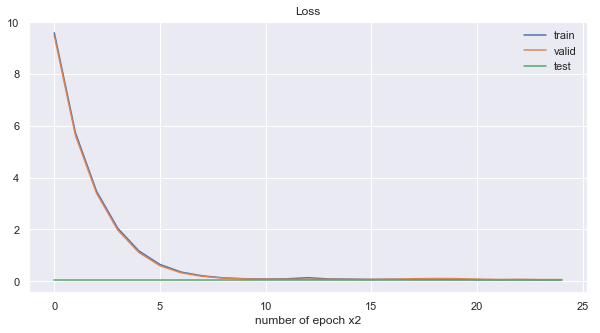

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

train_loss = train_metrics['train_loss']
valid_loss = train_metrics['valid_loss']
test_loss = test_metrics['test_loss']

plt.figure(figsize=(10,5))
plt.style.use('seaborn-white')
sns.set(font_scale=1)
plt.plot(train_loss,label='train');
plt.plot(valid_loss,label='valid');
plt.plot(np.tile(test_loss,len(train_loss)),label='test');
plt.title('Loss')
plt.xlabel('number of epoch x{}'.format(validate_after))
plt.legend()


Text(0.5,0,'ROI index')

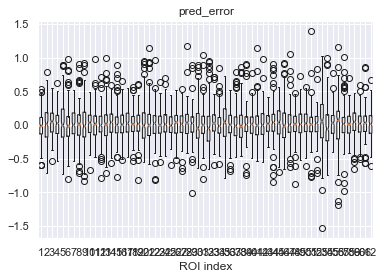

In [177]:
Y_act = Y_test[common_roi_cols].values
Y_pred = test_metrics['test_preds']
err = Y_act - Y_pred
plt.boxplot(err,'-o')
plt.title('pred_error')
plt.xlabel('ROI index'.format(validate_after))

In [172]:
Y_act.shape, Y_pred.shape

((180, 62), (719, 62))